In [1]:
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1_diff1/train_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1_diff1/test_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [3]:
import pickle

# Load the fitted DataScaler object
with open('../output/0_data_cleaning/lightgbm/lag1_diff1/data_preprocessor_lightgbm.pkl', 'rb') as f:
    data_preprocessor_lightgbm1 = pickle.load(f)

In [4]:
train_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,cement_co2_diff_lag1_lag2,coal_co2_diff_lag1_lag2,flaring_co2_diff_lag1_lag2,gas_co2_diff_lag1_lag2,land_use_change_co2_diff_lag1_lag2,oil_co2_diff_lag1_lag2,co2
0,1930,Argentina,0.007213,0.007274,0.026144,0.000370,0.001696,0.000000,0.000390,0.190037,0.001654,0.083932,0.450895,0.383763,0.483631,0.394886,0.502797,0.050794
1,1931,Argentina,0.007412,0.006756,0.026144,0.000402,0.001655,0.000000,0.000386,0.170616,0.001586,0.083376,0.450672,0.383763,0.482762,0.362219,0.502200,0.046617
2,1932,Argentina,0.007593,0.006527,0.026144,0.000564,0.001416,0.000000,0.000480,0.157812,0.002007,0.084164,0.449768,0.383763,0.483363,0.373169,0.504593,0.044323
3,1933,Argentina,0.007757,0.006839,0.026144,0.000525,0.001291,0.000000,0.000655,0.150694,0.002278,0.082950,0.450286,0.383763,0.483863,0.382579,0.503862,0.042756
4,1934,Argentina,0.007923,0.007399,0.026144,0.000540,0.001215,0.000000,0.000880,0.145852,0.002371,0.083273,0.450513,0.383763,0.484178,0.386343,0.502985,0.041755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,2003,Vietnam,0.060081,0.025702,0.026144,0.017601,0.005604,0.013673,0.003490,0.148809,0.011342,0.105137,0.453226,0.379675,0.490864,0.376707,0.508492,0.055115
3099,2004,Vietnam,0.060714,0.027628,0.026144,0.019924,0.006518,0.016147,0.004431,0.157641,0.011685,0.097285,0.455040,0.386280,0.488606,0.408968,0.504211,0.057655
3100,2005,Vietnam,0.061344,0.029640,0.026144,0.021913,0.007093,0.015907,0.007456,0.160666,0.013424,0.095258,0.453487,0.383519,0.501492,0.399361,0.511049,0.052390
3101,2006,Vietnam,0.061958,0.031614,0.026144,0.025491,0.008044,0.015322,0.007996,0.141767,0.013411,0.104905,0.455209,0.383167,0.486121,0.363083,0.502471,0.050074


In [5]:
# Ensure that 'country' is treated as a string
train_df['country'] = train_df['country'].astype(str)
test_df['country'] = test_df['country'].astype(str)

# Set up the lags
max_lag = 1  # Adjust as necessary
lags = list(range(1, max_lag + 1))

# List of dynamic features (excluding 'co2', 'year', and 'country')
dynamic_features = train_df.columns.drop(['co2', 'year', 'country']).tolist()

In [6]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        # 'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        # "max_depth": trial.suggest_int("max_depth", 3, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        # 'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 10.0),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.2),
        # 'random_state': 42,
        # 'objective': 'regression',
        # 'verbosity': 0,
        # 'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'random_state': 0, 
        'verbosity': -1
    }

    # Initialize the model
    model = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model = MLForecast(
        models=[model],
        freq=1,
        lags=lags,
        date_features=None,
        num_threads=-1
    )

    # Fit the model
    forecast_model.fit(
        train_df,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Perform cross-validation
    cv_predictions = forecast_model.cross_validation(
        df=train_df,
        h=5,
        n_windows=3,
        #step_size=1,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'LGBMRegressor': 'co2_predicted'})

    # Merge predictions with actual values
    results_train = cv_predictions.merge(
        train_df[['country', 'year', 'co2']],
        on=['country', 'year', 'co2'],
        how='left'
    )

    # Rename 'co2' to 'co2_actual'
    results_train = results_train.rename(columns={'co2': 'co2_actual'})

    # Drop any rows with NaNs
    results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])

    return mape

In [7]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 10.0),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.2),
        'random_state': 0,
        # 'objective': 'regression',
        'verbosity': -1,
        # 'n_jobs': -1,
    }

    # Initialize the model
    model = lgb.LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model = MLForecast(
        models=[model],
        freq=1,
        lags=lags,
        date_features=None,
        num_threads=-1
    )

    # Fit the model
    forecast_model.fit(
        train_df,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Perform cross-validation
    cv_predictions = forecast_model.cross_validation(
        df=train_df,
        h=5,
        n_windows=3,
        #step_size=1,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'LGBMRegressor': 'co2_predicted'})

    # Merge predictions with actual values
    results_train = cv_predictions.merge(
        train_df[['country', 'year', 'co2']],
        on=['country', 'year', 'co2'],
        how='left'
    )

    # Rename 'co2' to 'co2_actual'
    results_train = results_train.rename(columns={'co2': 'co2_actual'})

    # Drop any rows with NaNs
    results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])

    return mape

In [8]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-16 11:25:54,929] A new study created in memory with name: no-name-9e851980-c5f3-4f11-8ba0-cc62e436bb61
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-16 11:25:55,508] Trial 0 finished with value: 0.16753166459814864 and parameters: {'learning_rate': 0.029007322349494154, 'num_leaves': 46, 'max_depth': 5, 'lambda_l1': 4.704836285549178}. Best is trial 0 with value: 0.16753166459814864.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-16 11:25:56,004] Trial 1 finished with value: 0.10494638026745469 and parameters: {'learning_rate': 0.09101767979868809, 'num_leaves': 50, 'max_depth': 3, 'lambda_l1': 5.1614719087712295}. Best is trial 1 with value: 0.10494638026745469.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforec

Best Hyperparameters: {'learning_rate': 0.06509629980035958, 'num_leaves': 25, 'max_depth': 10, 'lambda_l1': 1.0470922254723758}


In [9]:
best_params

{'learning_rate': 0.06509629980035958,
 'num_leaves': 25,
 'max_depth': 10,
 'lambda_l1': 1.0470922254723758}

In [10]:
# Initialize the model with best hyperparameters
best_model = lgb.LGBMRegressor(
    **best_params,
    #objective='regression',
    #random_state=42,
    verbosity=-1,
    random_state = 0,
    #n_jobs=-1
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    #lags=lags,
    date_features=None,
    num_threads=-1
)

# Fit the model on the entire training data
# forecast_model.fit(
#     train_df,
#     id_col='country',
#     time_col='year',
#     target_col='co2',
#     static_features=[],
#     fitted=True
# )

train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


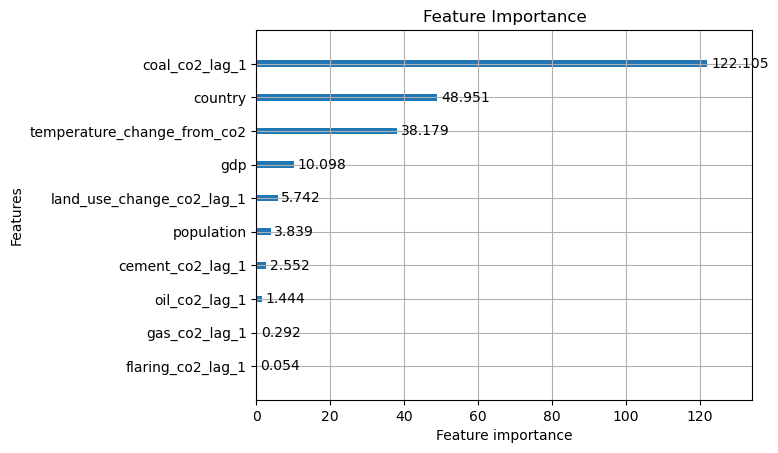

In [13]:
# Separate features and target
X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']

# Convert 'country' to a categorical feature
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
lgb.plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [12]:
#TRAIN DATA
# Get the fitted values on the training data
fitted_values = forecast_model.forecast_fitted_values()

# Rename 'LGBMRegressor' to 'co2_predicted'
fitted_values = fitted_values.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge fitted values with actual values
results_train = fitted_values.merge(
    train_df[['country', 'year', 'co2']],
    on=['country', 'year', 'co2'],
    how='left'
)

# Rename 'co2' to 'co2_actual'
results_train = results_train.rename(columns={'co2': 'co2_actual'})

# Drop any rows with NaNs
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])
print(results_train)

# Calculate the Mean Absolute Percentage Error (MAPE) on the training set
train_mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Exception: Please run the `fit` method using `fitted=True`

In [ ]:
results_train_inverse = results_train.copy()

In [ ]:
#predicted inverse transform
output = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data = data_preprocessor_lightgbm1.inverse_transform_data(output, results_train.shape[0], train_df.shape[1]-2)
last_column = inverted_data[:, -1]
results_train_inverse['co2_predicted'] = last_column
results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1930,0.050794,238.005387
1,Argentina,1931,0.046617,196.859925
2,Argentina,1932,0.044323,160.930540
3,Argentina,1933,0.042756,139.314474
4,Argentina,1934,0.041755,130.862385
...,...,...,...,...
3098,Vietnam,2003,0.055115,199.164635
3099,Vietnam,2004,0.057655,223.022718
3100,Vietnam,2005,0.052390,232.036895
3101,Vietnam,2006,0.050074,173.749667


In [ ]:
#actual inverse transform
output = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data = data_preprocessor_lightgbm1.inverse_transform_data(output, results_train.shape[0], train_df.shape[1]-2)
last_column = inverted_data[:, -1]
results_train_inverse['co2_actual'] = last_column
results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1930,194.678,238.005387
1,Argentina,1931,163.215,196.859925
2,Argentina,1932,145.940,160.930540
3,Argentina,1933,134.144,139.314474
4,Argentina,1934,126.606,130.862385
...,...,...,...,...
3098,Vietnam,2003,227.212,199.164635
3099,Vietnam,2004,246.341,223.022718
3100,Vietnam,2005,206.696,232.036895
3101,Vietnam,2006,189.254,173.749667


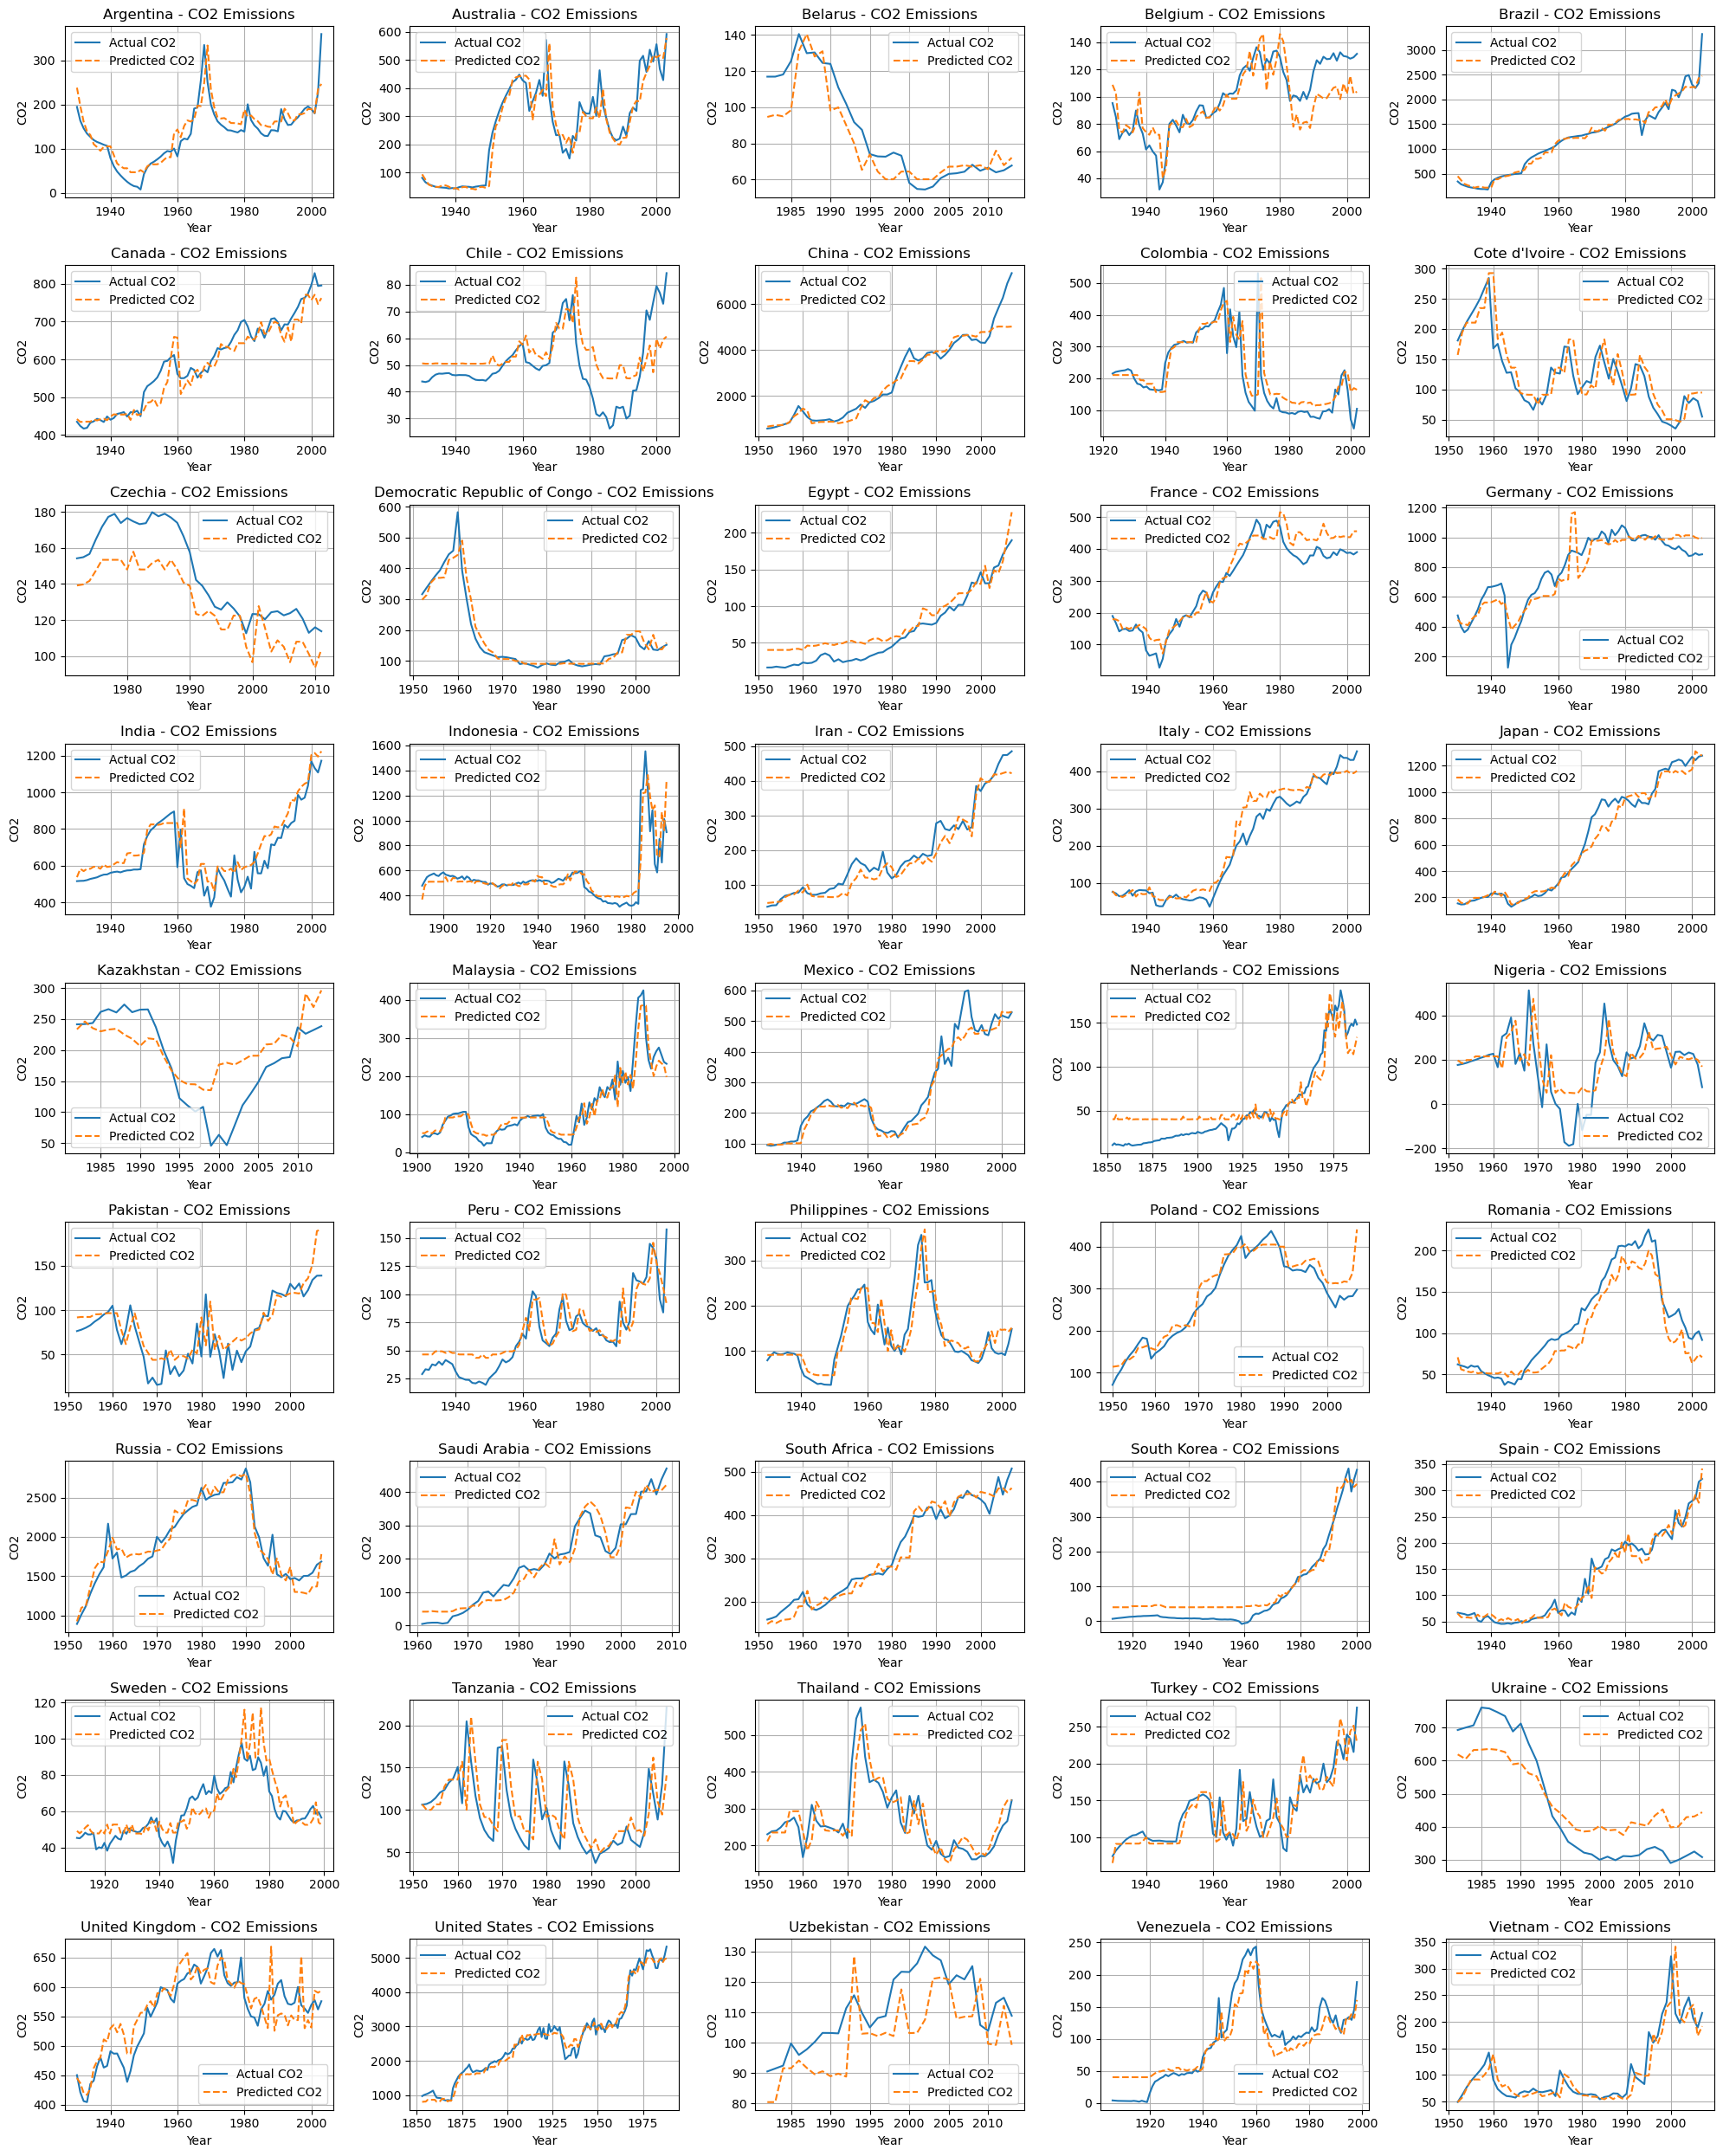

In [ ]:
#TRAIN DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_train_inverse['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train_inverse[results_train_inverse['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# TEST DATA
# Initialize an empty list to collect predictions
all_predictions = []

# Loop over each country in the test set
for country in test_df['country'].unique():
    # Select test data specific to this country
    country_test_data = test_df[test_df['country'] == country].copy()
    
    # Set the horizon to the number of years to predict for this country
    horizon = country_test_data['year'].nunique()
    
    # Drop the target column from the country-specific test data to avoid leakage
    country_test_features = country_test_data.drop(columns=['co2'])

    # Predict using the exact test data for this country
    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids = [country])
    
    # Add country identifier to the predictions for merging later
    country_predictions['country'] = country
    
    # Append to the list of all predictions
    all_predictions.append(country_predictions)

# Concatenate all country-specific predictions
predictions_df = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2'})

# Merge predictions with actual train values for comparison
results_test = predictions_df.merge(
    test_df[['country', 'year', 'co2']],
    on=['country', 'year'],
    how='left',
    suffixes=('_predicted', '_actual')
)

# # Display the first few rows of the predictions vs actuals
print(results_test)

# # Calculate the Mean Absolute Percentage Error (MAPE) on the test set
mape = mean_absolute_percentage_error(results_test['co2_actual'], results_test['co2_predicted'])
print(f"Test MAPE: {mape}")

       country  year  co2_predicted  co2_actual
0    Argentina  2004       0.064592    0.084815
1    Argentina  2005       0.076030    0.089670
2    Argentina  2006       0.080167    0.092114
3    Argentina  2007       0.083415    0.071866
4    Argentina  2008       0.078255    0.063909
..         ...   ...            ...         ...
801    Vietnam  2018       0.087323    0.091968
802    Vietnam  2019       0.086844    0.103267
803    Vietnam  2020       0.091406    0.106353
804    Vietnam  2021       0.092161    0.105343
805    Vietnam  2022       0.090600    0.103998

[806 rows x 4 columns]
Test MAPE: 0.20902260295157535


In [ ]:
results_test_inverse = results_test.copy()

In [ ]:
#predicted inverse transform
output = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data = data_preprocessor_lightgbm1.inverse_transform_data(output, results_test.shape[0], test_df.shape[1]-2)
last_column = inverted_data[:, -1]
results_test_inverse['co2_predicted'] = last_column
results_test_inverse

,country,year,co2_predicted,co2_actual
0,Argentina,2004,298.585602,0.084815
1,Argentina,2005,384.721369,0.089670
2,Argentina,2006,415.875957,0.092114
3,Argentina,2007,440.336191,0.071866
4,Argentina,2008,401.477676,0.063909
...,...,...,...,...
801,Vietnam,2018,469.767875,0.091968
802,Vietnam,2019,466.161606,0.103267
803,Vietnam,2020,500.513356,0.106353
804,Vietnam,2021,506.205627,0.105343


In [ ]:
#actual inverse transform
output = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data = data_preprocessor_lightgbm1.inverse_transform_data(output, results_test.shape[0], test_df.shape[1]-2)
last_column = inverted_data[:, -1]
results_test_inverse['co2_actual'] = last_column
results_test_inverse

,country,year,co2_predicted,co2_actual
0,Argentina,2004,298.585602,450.881
1,Argentina,2005,384.721369,487.442
2,Argentina,2006,415.875957,505.851
3,Argentina,2007,440.336191,353.365
4,Argentina,2008,401.477676,293.438
...,...,...,...,...
801,Vietnam,2018,469.767875,504.751
802,Vietnam,2019,466.161606,589.843
803,Vietnam,2020,500.513356,613.079
804,Vietnam,2021,506.205627,605.475


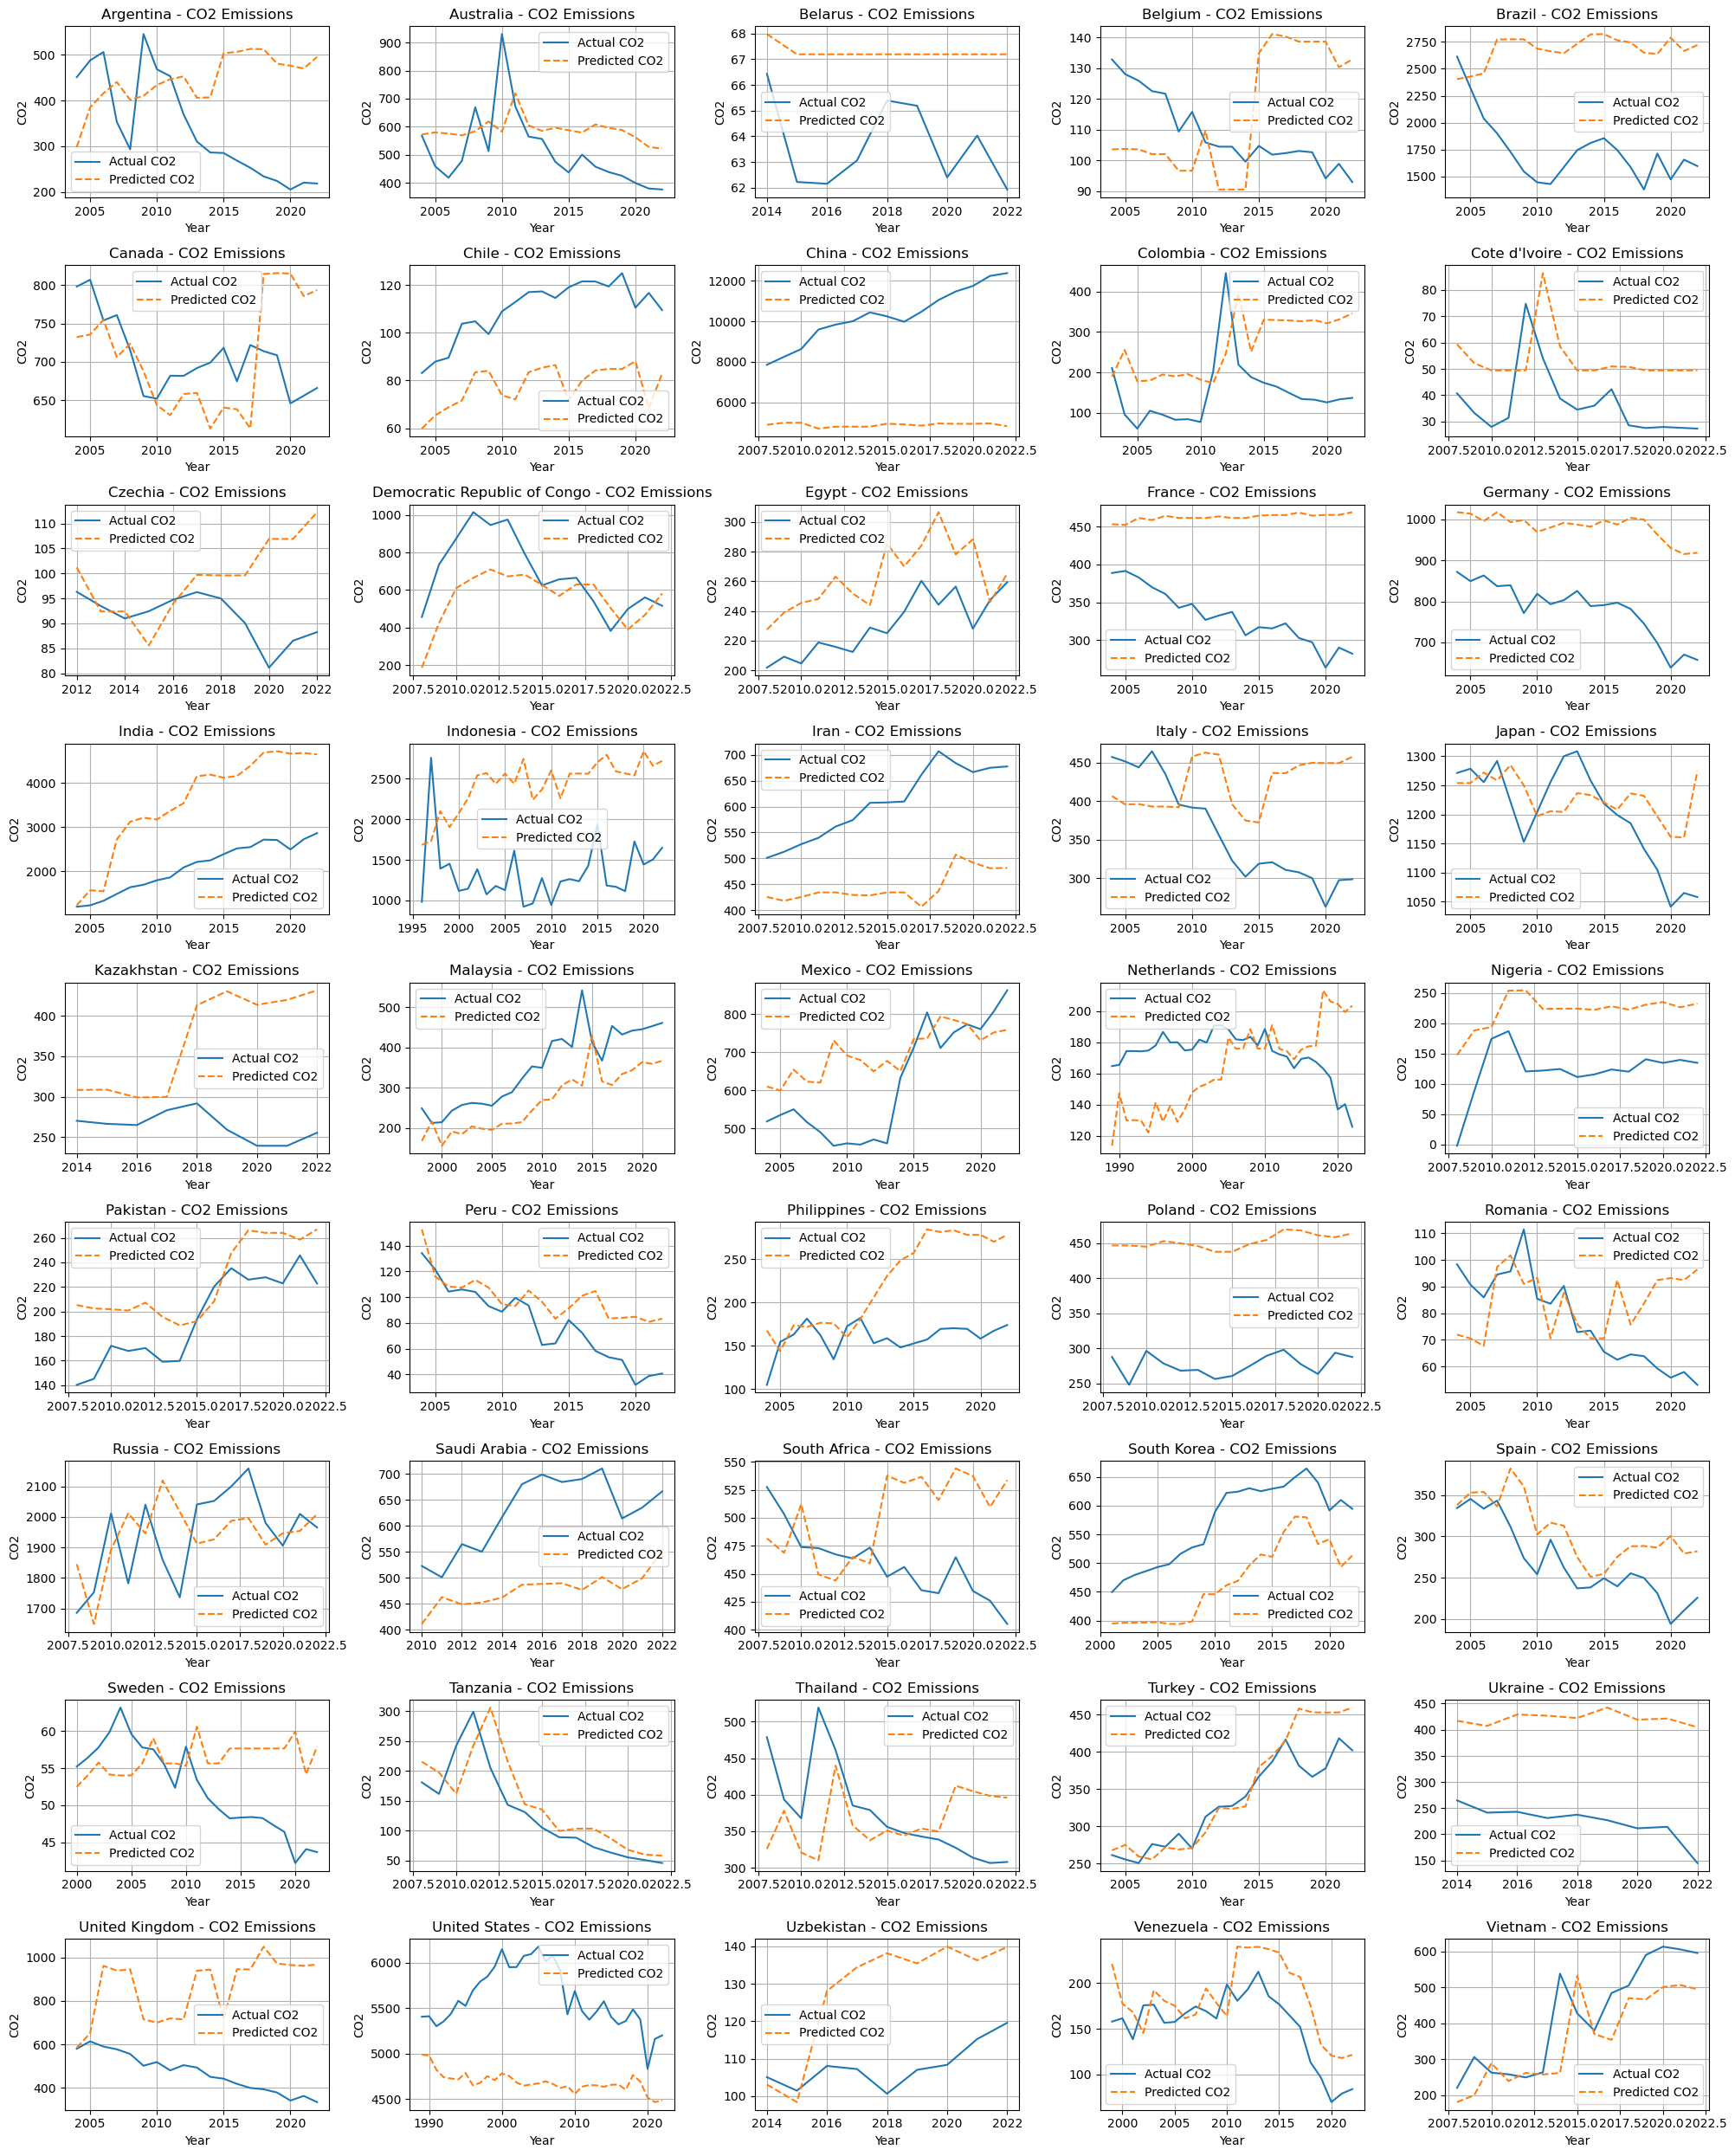

In [ ]:
#TEST DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_test_inverse['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test_inverse[results_test_inverse['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
mape_trian = mean_absolute_percentage_error(results_train_inverse['co2_actual'], results_train_inverse['co2_predicted'])
print(mape_trian)
mape_test = mean_absolute_percentage_error(results_test_inverse['co2_actual'], results_test_inverse['co2_predicted'])
print(mape_test)

0.5686553545829965
0.4278599434957195


In [ ]:
results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1930,194.678,238.005387
1,Argentina,1931,163.215,196.859925
2,Argentina,1932,145.940,160.930540
3,Argentina,1933,134.144,139.314474
4,Argentina,1934,126.606,130.862385
...,...,...,...,...
3098,Vietnam,2003,227.212,199.164635
3099,Vietnam,2004,246.341,223.022718
3100,Vietnam,2005,206.696,232.036895
3101,Vietnam,2006,189.254,173.749667


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = results_train_inverse

# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in df['country'].unique():
    country_df = df[df['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:  # Ensure there are at least two samples
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan  # Assign NaN if not enough samples
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = df['co2_actual']
overall_predicted = df['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)

Metrics by country:
                         country       MAPE         MAE        RMSE        R2
0                      Argentina   0.325877   21.907472   29.653407  0.797128
1                      Australia   0.129991   35.086973   56.966366  0.875019
2                        Belarus   0.105964    9.667742   12.360605  0.797615
3                        Belgium   0.132731   12.653859   16.130631  0.595090
4                         Brazil   0.075568   75.414273  131.227973  0.963857
5                         Canada   0.041185   24.951775   33.584589  0.911997
6                          Chile   0.188708    8.443808   10.586287  0.332183
7                          China   0.105276  288.149800  505.383327  0.919934
8                       Colombia   0.280329   41.218431   71.960450  0.601330
9                  Cote d'Ivoire   0.207695   22.728532   30.397332  0.723093
10                       Czechia   0.118012   17.599278   19.242131  0.379330
11  Democratic Republic of Congo   0.100644 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = results_test_inverse

# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in df['country'].unique():
    country_df = df[df['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:  # Ensure there are at least two samples
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan  # Assign NaN if not enough samples
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = df['co2_actual']
overall_predicted = df['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
results_by_country_df
print("\nOverall metrics:")
print(overall_metrics_df)

Metrics by country:

Overall metrics:
   country     MAPE         MAE        RMSE        R2
0  Overall  0.42786  309.952659  872.479261  0.748628


In [ ]:
results_by_country_df

,country,MAPE,MAE,RMSE,R2
0,Argentina,0.596151,160.949769,182.937008,-1.804102
1,Australia,0.249188,121.081432,140.945911,-0.190997
2,Belarus,0.057679,3.633668,3.907492,-5.127208
3,Belgium,0.239277,25.413311,27.854052,-4.871493
4,Brazil,0.589952,958.106579,1015.185137,-10.295592
5,Canada,0.097800,68.163701,82.173939,-2.183716
6,Chile,0.286660,31.791202,33.093702,-6.857044
7,China,0.515964,5389.747207,5549.495527,-16.749197
8,Colombia,1.085653,137.799227,149.428217,-2.370683
9,Cote d'Ivoire,0.585453,20.086904,20.751505,-1.779657
